In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from qiskit import Aer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.components.multiclass_extensions.one_against_rest import OneAgainstRest
from qiskit.aqua.algorithms.many_sample.qsvm import _QSVM_Estimator
from qiskit.aqua.algorithms import QSVM
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
def Data(dataset, n, PLOT_DATA):
    class_labels = [r'Setosa', r'Versicolor', r'Virginica']
    data, target = datasets.load_iris(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=.3, random_state=7070)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    training_input = {key: (sample_train[label_train == k, :]) for k, key in enumerate(class_labels)}
    test_input =  {key: (sample_test[label_test == k, :]) for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0],
                        sample_train[label_train == k, 1])

        plt.title("Iris dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

In [4]:
feature_dim = 2 # dimension of each data point

dataset=datasets.load_iris()
sample_Total, training_input, test_input, class_labels = Data(datasets.load_iris(True),
                                                              n=feature_dim, PLOT_DATA=False)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

{'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


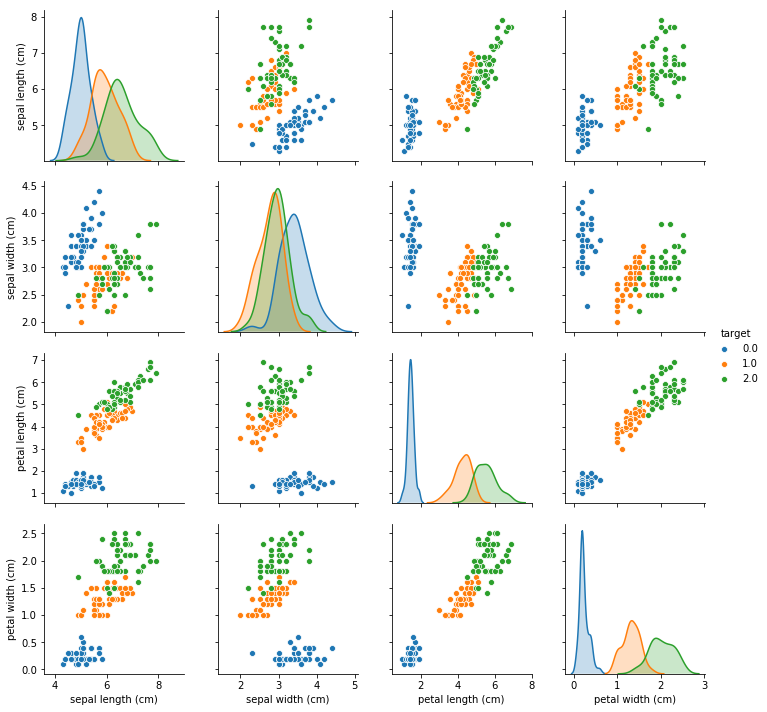

In [5]:
df = pd.DataFrame( np.c_[dataset['data'], dataset['target']],
                         columns = np.append(dataset['feature_names'], ['target']))
sns.pairplot(df, hue = 'target', 
             vars = ['sepal length (cm)', 'sepal width (cm)',
                     'petal length (cm)', 'petal width (cm)'] )

In [6]:
params={
    'problem': {'name': 'classification', 'random_seed': 10598},
    'algorithm': {'name': 'QSVM'},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2},
    'multiclass_extension': {'name': 'AllPairs'},
    'backend': { 'name': 'ibmq_20_tokyo', 'shots': 1024}}

backend = Aer.get_backend('qasm_simulator')
algo_input = ClassificationInput(training_input, test_input, datapoints[0])

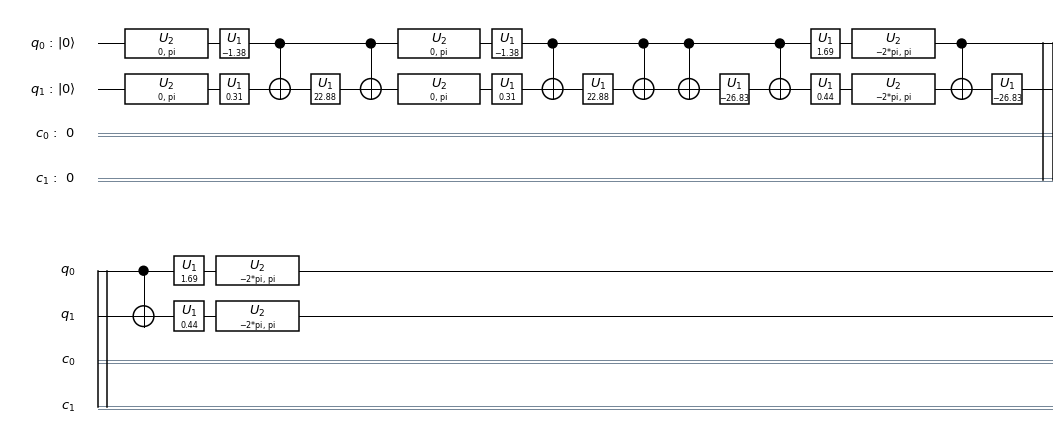

In [7]:
feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0], OneAgainstRest(_QSVM_Estimator))
qc = qsvm.construct_circuit(x1=datapoints[0][0], x2=datapoints[0][1]) # these are two data points.
qc.draw()

In [8]:
%time result = run_algorithm(params, algo_input, backend=backend)

Entry point 'HartreeFock = qiskit.chemistry.aqua_extensions.components.initial_states:HartreeFock' requirements issue: (jsonschema 3.0.1 (/opt/conda/lib/python3.7/site-packages), Requirement.parse('jsonschema<2.7,>=2.6'), {'qiskit-aqua'})
Entry point 'UCCSD = qiskit.chemistry.aqua_extensions.components.variational_forms:UCCSD' requirements issue: (jsonschema 3.0.1 (/opt/conda/lib/python3.7/site-packages), Requirement.parse('jsonschema<2.7,>=2.6'), {'qiskit-aqua'})
/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:547: DeprecationWarning: IBMQ.backends() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.backends() to find its backends.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:594: DeprecationWarning: IBMQ.get_backend() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.get_backend("name") to retrieve a backend.
  Depr

CPU times: user 9min 28s, sys: 1min 5s, total: 10min 34s
Wall time: 24min 12s


In [9]:
print("ground truth:    {}".format(datapoints[1]))
print("prediction:      {}".format(result['predicted_labels']))
print("predicted class: {}".format(result['predicted_classes']))
print("accuracy:        {}".format(result['testing_accuracy']))

ground truth:    [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
prediction:      [0 0 1 2 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 2 1 1 1 1 2 1 1 2 1 1 2 2 2 2 2 2 2
 2 1 2 2 2 1 2 2]
predicted class: ['Setosa', 'Setosa', 'Versicolor', 'Virginica', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Versicolor', 'Versicolor', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Versicolor', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Versicolor', 'Virginica', 'Virginica', 'Virginica', 'Versicolor', 'Virginica', 'Virginica']
accuracy:        0.8222222222222222


In [10]:
print(classification_report(datapoints[1], result['predicted_labels'], 
                            target_names=dataset.target_names))

              precision    recall  f1-score   support

      setosa       1.00      0.85      0.92        13
  versicolor       0.81      0.76      0.79        17
   virginica       0.72      0.87      0.79        15

    accuracy                           0.82        45
   macro avg       0.84      0.83      0.83        45
weighted avg       0.84      0.82      0.83        45



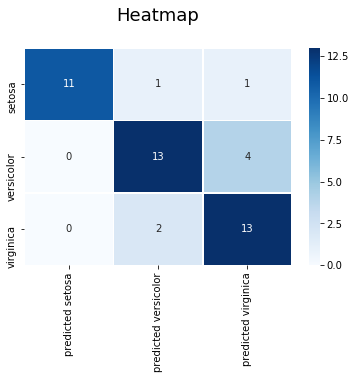

In [11]:
cm = np.array(confusion_matrix(datapoints[1], result['predicted_labels']))
confusion = pd.DataFrame(cm, index=dataset.target_names, 
                         columns= ['predicted ' + s for s in dataset.target_names])

sns.heatmap(confusion, annot=True, fmt="d", linewidths=.5, cmap="Blues")
plt.title("Heatmap\n", fontdict = {'fontsize': 18})
plt.show()